## Trabajo 1: Solución lineal de sistemas lineales en Julia

* Objetivo:Comparar diferentes métodos de resolución de sistemas lineales de gran tamaño con un problema de EDP que genera matrices no simétricas en base a los parámetros N, α y ε=1

$$\beta \cdot \bigtriangledown u-\epsilon \bigtriangleup u=0 $$

$$ \beta =\alpha (\frac{\sqrt{2}}{2},\frac{\sqrt{2}}{2})^T $$

Contenido: utilizar el código en python (basado en el código Matlab de A. Meister, Aufgabe 6) y las librerías Julia de C.T. Kelley en https://github.com/ctkelley

Metodología: realizar un notebook de jupyter en Julia con gráficas y tablas de errores y tiempos de cómputo en base a las iteraciones

In [11]:
aux=false
if aux==true
    import Pkg
    Pkg.add("IterativeSolvers")
    Pkg.add("LinearAlgebra")
    Pkg.add("SparseArrays")
    Pkg.add("BenchmarkTools")
end

In [5]:
using LinearAlgebra
using SparseArrays
function Tarea1(N,a,b,tol,maxit)
    dx = 1 / (N + 1);

    e = ones(N);
    Dxx = spdiagm(-1 => e[1:N-1] , 0 => -2 * e  , 1 => e[1:N-1]);   # 1D central difference

    ident = Matrix{Float64}(I, N, N);
    x = kron(ident, Dxx) / (dx^2);  # 2nd derivative with respect to x

    Axx = kron(ident, Dxx) / (dx^2); # 2nd derivative with respect to x
    Ayy = kron(Dxx, ident) / (dx^2);  # 2nd derivative with respect to y

    Dx = spdiagm( -1 => e[1:N-1] , 1 => e[1:N-1]);  # 1D central difference
    Ax = kron(ident, Dx) / (2 * dx);

    I_2 = sparse(Matrix{Float64}(I, N*N, N*N));

    A = -Axx - Ayy - a * Ax - b * I_2;  # Matrix
    B = ones(N * N);  # Right-hand side
    u0 = 0.5 * ones(N * N);  # Initial guess

    return A, B, u0;
end

Tarea1 (generic function with 1 method)

1. Utilizar métodos directo LU y Choleski para matrices simétricas, y los métodos iterativos CG, BiCG , BiCGStab , GMRES , LGMRES, MINRES, QMR que encuentren en las librerías de Julia. Si encuentran otros , los aportan

Metodos directos:

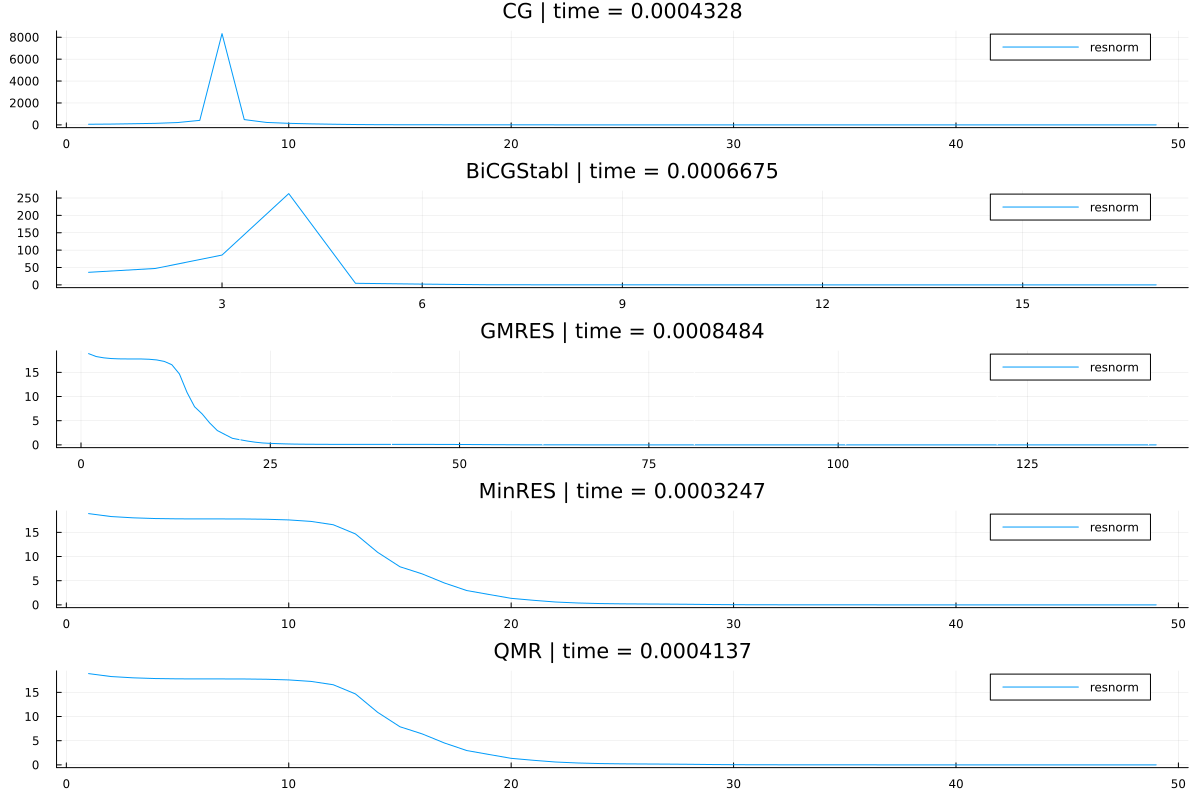

In [8]:
import LinearAlgebra
using BenchmarkTools
N=20; a=1 ; b=2 ; tol=1e-6 ; maxit=100000 ;
A,b,u0 = Tarea1(N,a,b,tol,maxit);
#Calcular descomposicion LU
lu_decomposition = lu(A);
L = lu_decomposition.L;U = lu_decomposition.U;P = lu_decomposition.p;
#cholesky
using LinearAlgebra
#L_cholesky = cholesky(A);


#Metodos Iterativos
using IterativeSolvers
#CG
tcg = @elapsed begin
    xcg,hcg=cg(A,b,log=true,maxiter=maxit);
end
#bicgstab
tbicgstab = @elapsed begin
    xbicgstabl,hbicgstabl=bicgstabl(A,b,log=true)
end
#gmres
tgmres = @elapsed begin
    xgmres,hgmres=gmres(A,b,log=true);
end

#minres
tminres = @elapsed begin
    xminres,hminres = minres(A,b,log=true);   
end

#qmr
tqmr = @elapsed begin
    xqmr,hqmr=qmr(A,b,log=true);    
end

#using KrylovKit
#BiCG
#xbicg,hbicg=bicg(A,b)

#LGMRESusing
#xlgmres,hgmres=lgmres(A,b,log=true)


using Plots
plot1 = plot(hcg,title="CG | time = $tcg")
plot2 = plot(hbicgstabl,title="BiCGStabl | time = $tbicgstab")
plot3 = plot(hgmres,title="GMRES | time = $tgmres")
plot4 = plot(hminres,title="MinRES | time = $tminres")
plot5 = plot(hqmr,title="QMR | time = $tqmr")

layout = @layout[a ; b ; c ; d ; e]

p=plot( plot1, plot2, plot3, plot4, plot5, layout=layout, size=(1200,800));
p

**ConvergenceHistory keys**

- `:tol` => `::Real`: stopping tolerance.
- `:resnom` => `::Vector`: residual norm at each iteration.
- `history.mvps`: number of matrix vector products.
- `history.mtvps`: number of transposed matrix-vector products
- `history.iters`: iterations taken by the method
- `history.isconverged`: convergence of the method.
- `history.data`:  Stores all the information stored during the method execution. It stores tolerances, residuals and other information.

2. Utilizar escenarios de N y α en base a la presentación . Utilizar el mayor N possible con tiempos esperables menos de una hora).

In [30]:
using IterativeSolvers
using BenchmarkTools
# Parameters
a = 3;   # Advection parameter
b = 5;     # Reaction parameter
tol = 1e-6;    # Tolerance for stopping criterion
maxit = 100000;  # Maximum number of iterations
n=[20,40,60,80];

XCG=[]        ; HCG=[]       ; TCG=[]       ;
XBICGSTAB=[]  ; HBICGSTAB=[] ; TBICGSTAB=[] ;
XGMRES=[]     ; HGMRES=[]    ; TGMRES=[]    ;
XMINRES=[]    ; HMINRES=[]   ; TMINRES=[]   ;
XQMR=[]       ; HQMR=[]      ; TQMR=[]      ;

 for N in n
  A,B,u0 = Tarea1(N,a,b,tol,maxit);

  #CG
  tcg = @elapsed begin
      xcg , hcg = cg(A,B,log=true,maxiter=maxit);
  end
  push!(XCG,xcg) ; push!(HCG,hcg); push!(TCG,tcg);

   #bicgstab
  tbicgtab = @elapsed begin
    xbicgstab , hbicgstab = bicgstabl(A,B,log=true);
  end
  push!(XBICGSTAB,xbicgstab) ; push!(HBICGSTAB,hbicgstab); push!(TBICGSTAB,tbicgtab);

  #gmres
  tgmres = @elapsed begin
    xgmres , hgmres = gmres(A,B,log=true);  
  end
  push!(XGMRES,xgmres) ; push!(HGMRES,hgmres); push!(TGMRES,tgmres);
  
  #minresgi
  tminres = @elapsed begin
    xminres , hminres = minres(A,B,log=true);  
  end
  push!(XMINRES,xminres) ; push!(HMINRES,hminres); push!(TMINRES,tminres);
  
  #qmr
  tqmr = @elapsed begin
    xqmr , hqmr = qmr(A,B,log=true);  
  end
  push!(XQMR,xqmr) ; push!(HQMR,hqmr); push!(TQMR,tqmr);
 end

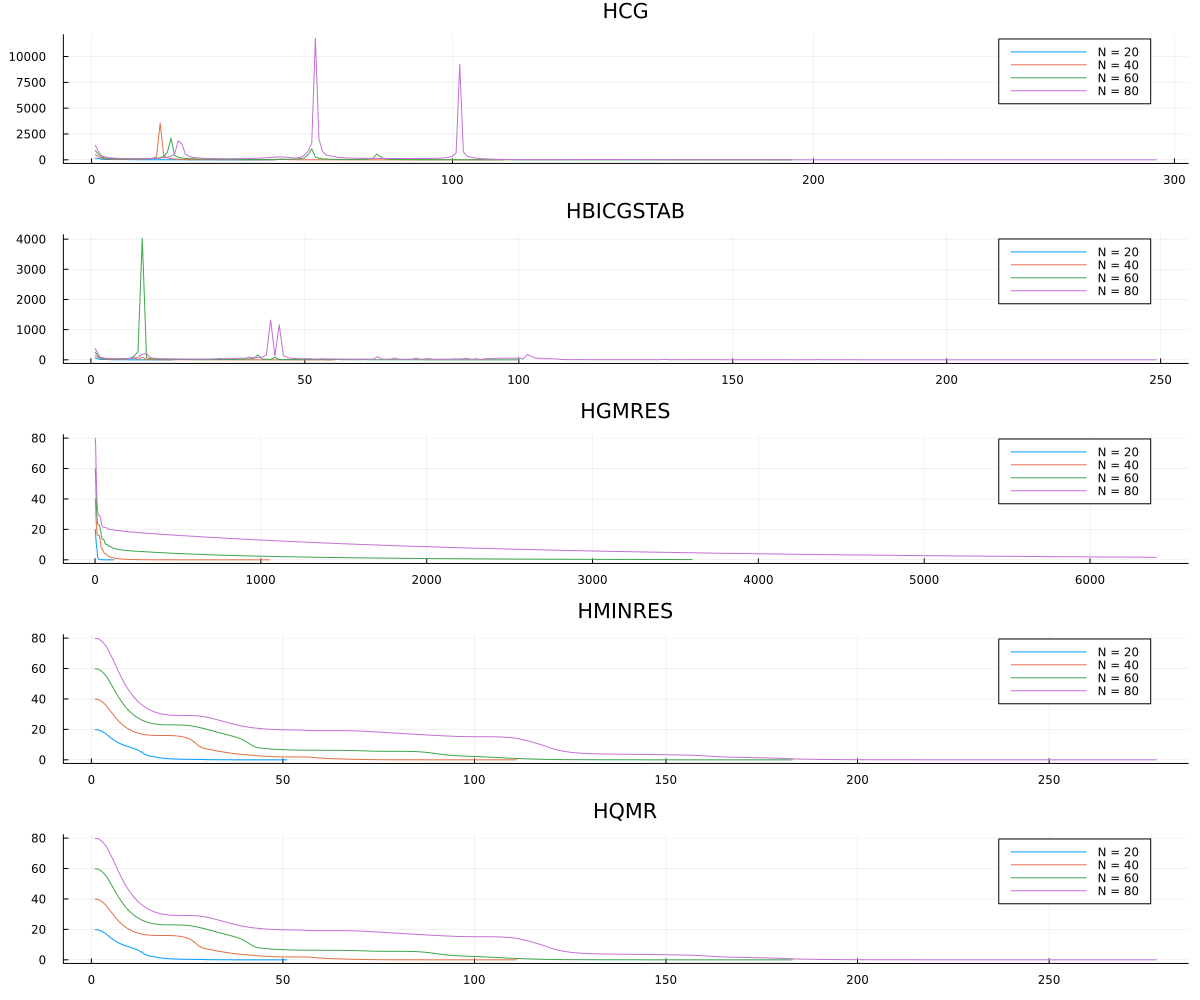

In [32]:
using Plots
metodos=[ HCG , HBICGSTAB , HGMRES , HMINRES , HQMR ];
nombres=["HCG","HBICGSTAB","HGMRES","HMINRES","HQMR"];
layout= @layout [a ; b ; c ; d ; e];
p=plot(layout=layout,size=(1200,1000))

for (i,metodo) in enumerate(metodos)
    nombre=nombres[i]; 
    for (j,valor) in enumerate(n)
        aux=n[j];
        label= "N = $aux";
        x=[x for x in 1:length( metodo[j][:resnorm] )];
        y=metodo[j][:resnorm];
        plot!(p[i],x,y,label=label,title="$nombre")  
    end        
end
p

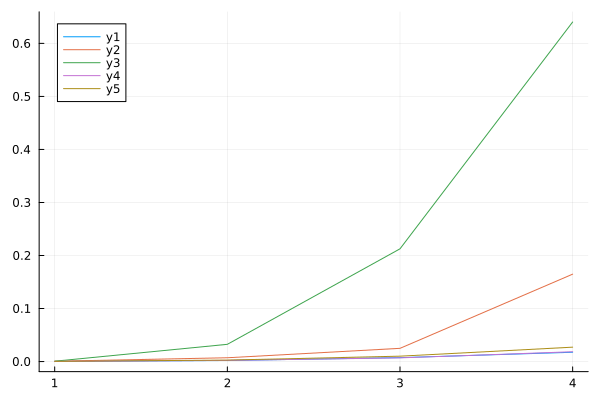

In [39]:
using Plots
tiempos=[ TCG , TBICGSTAB , TGMRES , TMINRES , TQMR ];
p=plot();
for tiempo in tiempos
    plot!(tiempo)
end
p


In [33]:
using Plots


3. Calcular tiempos y errores en base a las iteraciones de los métodos iterativos y comparar con los métodos directos

4. Analizar los resultados y decidir el métodos más rápido y preciso para cada escenario de N y α.

5. Encontrar las propiedades de las matrices generadas por la linearización en redes neuronales y proponer qué método sería el major para problemas de alta dimensionalidad .